# Pain report analysis from locohab data collection
### Description:
Participants perfored 8 walking trials under 2 different conditions (4 each). Pain ratings were provided every 30 seconds.

### Purpose
Examine the relationship of pain intensity over time (linear, exponential decay?)


In [1]:
# load libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from utils import fitting

In [2]:
# load data
d = pd.read_excel("../locohab data.xlsx", sheet_name="painratings")
d.head()

,pid,session,trial,paincond,5,30,60,90,120,150,...,330,360,390,420,450,480,510,540,570,600
0,1,1,1,T,3.00,4.00,3.00,2.25,2.50,3.0,...,0.90,0.5,0.30,1.0,0.5,1.75,2.75,3.5,1.25,2.25
1,1,1,2,T,3.00,3.50,2.00,1.00,1.00,1.5,...,1.25,2.5,1.00,3.5,2.0,0.90,1.75,3.0,3.75,1.50
2,1,1,3,T,3.25,2.75,1.25,0.90,1.75,1.0,...,2.50,2.0,1.50,1.0,0.5,1.00,0.80,0.5,1.25,1.00
3,2,1,1,T,3.00,2.75,2.75,2.75,2.75,2.5,...,2.00,2.0,2.25,2.0,2.0,2.00,2.00,2.0,2.00,2.00
4,2,1,2,T,3.00,2.50,2.50,2.50,2.50,2.5,...,2.00,2.0,2.25,2.0,2.0,1.50,1.50,1.5,1.00,1.00


In [3]:
# remove any remaining participant place holders
d = d.dropna()

# set column headers to strings
d.columns = d.columns.astype(str)

# generate timepoints vector
timepoints = np.arange(30, 630, 30).reshape(1, 20)  # up to 630 so 600 is included.

# combine trial and condition columns
pid = d.loc[:, "pid"].to_numpy()

In [4]:
# rearange data
# y = d.loc[:, "30":"600"].to_numpy().reshape((1, d.shape[0] * timepoints.shape[0]))

tonic_data = pd.melt(
    d,
    id_vars=["pid", "session", "trial", "paincond"],
    value_vars=d.columns[3:].to_numpy(),
    value_name="painrating",
    var_name="timepoint",
).reset_index(drop=True)

tonic_data["timepoint"] = tonic_data["timepoint"].astype(int)

## Fit pain ratings as function of time

In [6]:
# mean fit Linear
tonic_fits = {"overall": {"linear": {}, "exp": {}}}

(
    tonic_fits["overall"]["linear"]["coeffs"],
    tonic_fits["overall"]["linear"]["cov"],
    tonic_fits["overall"]["linear"]["info"],
    _,
) = fitting.fit_lin(tonic_data["timepoint"], tonic_data["painrating"])
tonic_fits["overall"]["linear"]["ypred"] = fitting.linear(
    timepoints, *tonic_fits["overall"]["linear"]["coeffs"]
)

# Mean exponential decay fit
(
    tonic_fits["overall"]["exp"]["coeffs"],
    tonic_fits["overall"]["exp"]["cov"],
    tonic_fits["overall"]["exp"]["info"],
    _,
) = fitting.fit_exp(tonic_data["timepoint"], tonic_data["painrating"])
tonic_fits["overall"]["exp"]["ypred"] = fitting.exponential(
    timepoints, *tonic_fits["overall"]["exp"]["coeffs"]
)

In [8]:
# For each participant

tonic_fits["participant"] = {
    "linear": {"coeffs": {}, "cov": {}, "info": {}, "ypred": {}},
    "exp": {"coeffs": {}, "cov": {}, "info": {}, "ypred": {}},
}

for i in np.unique(tonic_data["pid"]):
    # fit linear
    tonic_data_filt = tonic_data.loc[tonic_data["pid"] == i, :]
    (
        tonic_fits["participant"]["linear"]["coeffs"][i],
        tonic_fits["participant"]["linear"]["cov"][i],
        tonic_fits["participant"]["linear"]["info"][i],
        _,
    ) = fitting.fit_lin(tonic_data_filt["timepoint"], tonic_data_filt["painrating"])
    tonic_fits["participant"]["linear"]["ypred"][i] = fitting.linear(
        timepoints, *tonic_fits["participant"]["linear"]["coeffs"][i]
    )
    # Fit Exponential Decay
    (
        tonic_fits["participant"]["exp"]["coeffs"][i],
        tonic_fits["participant"]["exp"]["cov"][i],
        tonic_fits["participant"]["exp"]["info"][i],
        _,
    ) = fitting.fit_exp(tonic_data_filt["timepoint"], tonic_data_filt["painrating"])
    tonic_fits["participant"]["exp"]["ypred"][i] = fitting.exponential(
        timepoints, *tonic_fits["participant"]["exp"]["coeffs"][i]
    )

['rgb(229, 134, 6)',
 'rgb(93, 105, 177)',
 'rgb(82, 188, 163)',
 'rgb(153, 201, 69)',
 'rgb(204, 97, 176)',
 'rgb(36, 121, 108)',
 'rgb(218, 165, 27)',
 'rgb(47, 138, 196)',
 'rgb(118, 78, 159)',
 'rgb(237, 100, 90)',
 'rgb(165, 170, 153)']

## Visualize pain ratings as function of time

In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

p_colours = px.colors.qualitative.Vivid

tonic_data["pid"] = tonic_data["pid"].astype(str)
participant_numbers = np.unique(tonic_data["pid"])
fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles=("Linear Fit", "Exponential Fit"),
                    x_title="Time (s)", y_title="Pain rating (0-10)",
                    horizontal_spacing=0.02, vertical_spacing=0.1)
# fig = go.Figure()
for p in participant_numbers:
    p=int(p)
    # point data
    fig.add_trace(
        go.Scatter(
            x=tonic_data["timepoint"][tonic_data["pid"] == str(p)],
            y=tonic_data["painrating"][tonic_data["pid"] == str(p)]
            .to_numpy()
            .flatten(),
            mode="markers",
            name=f"P{p}",
            marker=dict(size=10, opacity=0.8, color=p_colours[p]), #px.colors.qualitative.D3[p]),
            showlegend=False
        ), row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tonic_data["timepoint"][tonic_data["pid"] == str(p)],
            y=tonic_data["painrating"][tonic_data["pid"] == str(p)]
            .to_numpy()
            .flatten(),
            mode="markers",
            name=f"P{p}",
            marker=dict(size=10, opacity=0.8, color=p_colours[p]), #px.colors.qualitative.D3[p]),
            showlegend=False
        ), row=1, col=2
    )

    # fitted data
    fig.add_trace(
        go.Scatter(
            x=timepoints.flatten(),
            y=tonic_fits["participant"]["linear"]["ypred"][p].flatten(), 
            mode="lines",
            name=f"P{p}",
            line=dict(dash="solid", color=p_colours[p]), #px.colors.qualitative.D3[p]),
        ), row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=timepoints.flatten(),
            y=tonic_fits["participant"]["exp"]["ypred"][p].flatten(), 
            mode="lines",
            name=f"P{p}",
            line=dict(dash="solid", color=p_colours[p]), #px.colors.qualitative.D3[p]),
            showlegend=False
        ), row=1, col=2
    )
fig.add_trace(
    go.Scatter(
        x=timepoints.flatten(),
        y=tonic_fits["overall"]["linear"]["ypred"].flatten(),
        mode="lines",
        name="Overall Fit",
        line=dict(dash="dash", color="white", width=4),
    ),row=1, col=1,
)
fig.add_trace(
    go.Scatter(
        x=timepoints.flatten(),
        y=tonic_fits["overall"]["exp"]["ypred"].flatten(),
        mode="lines",
        name="Overall Fit",
        line=dict(dash="dash", color="white", width=4),
        showlegend=False
    ),row=1, col=2
)

fig.update_traces(
    marker_size=5,
    marker_opacity=0.8,
)

fig.update_layout(
    width=1200,
    height=600,
    template="plotly_dark",
    title="Pain ratings over time for each participant and overall fit",
    legend=dict(orientation="v")
)
fig.update_xaxes(range=[-5, 605])

fig.show()

In [55]:
import plotly.graph_objects as go

tonic_data["pid"] = tonic_data["pid"].astype(str)
participant_numbers = np.unique(tonic_data["pid"])
p_colours = px.colors.qualitative.Vivid
fig = go.Figure()
for p in participant_numbers:
    p=int(p)
    fig.add_trace(
        go.Scatter(
            x=tonic_data["timepoint"][tonic_data["pid"] == str(p)],
            y=tonic_data["painrating"][tonic_data["pid"] == str(p)]
            .to_numpy()
            .flatten(),
            mode="markers",
            name=f"P{p}",
            marker=dict(size=10, opacity=0.8, color=p_colours[p]),#px.colors.qualitative.D3[p]),
            showlegend=False
        )
    )
    fig.add_trace(
        go.Scatter(
            x=timepoints.flatten(),
            y=tonic_fits["participant"]["linear"]["ypred"][p].flatten(), 
            mode="lines",
            name=f"P{p}",
            line=dict(dash="solid", color=p_colours[p]),#px.colors.qualitative.D3[p]),
        )
    )
fig.add_trace(
    go.Scatter(
        x=timepoints.flatten(),
        y=tonic_fits["overall"]["linear"]["ypred"].flatten(),
        mode="lines",
        name="Overall fit",
        line=dict(dash="dash", color="white", width=4),
    )
)
fig.update_traces(
    marker_size=5,
    marker_opacity=0.8,
)
fig.update_layout(
    xaxis_title="Time (s)",
    yaxis_title="Pain rating (0-10)",
    width=800,
    height=600,
    template="plotly_dark",
    title="Pain ratings over time for each participant and overall fit",
    # colorway=px.colors.qualitative.D3,
)
fig.update_xaxes(range=[-5, 605])

fig.show()

### Connected point-line plot of data (no fitting)

In [58]:
import plotly.graph_objects as go

tonic_data["pid"] = tonic_data["pid"].astype(str)
participant_numbers = np.unique(tonic_data["pid"])
p_colours = px.colors.qualitative.Vivid
fig = go.Figure()
for p in participant_numbers:
    for t in range(1,4):  # trials
        p=int(p)
        fig.add_trace(
            go.Scatter(
                x=tonic_data["timepoint"][(tonic_data["pid"] == str(p)) & (tonic_data["trial"] == t)],
                y=tonic_data["painrating"][(tonic_data["pid"] == str(p)) & (tonic_data["trial"] == t)]
                .to_numpy()
                .flatten(),
                mode='lines+markers',
                name=f"P{p}",
                marker=dict(size=10, opacity=0.8, color=p_colours[p]),
                showlegend = False if t>1 else True
            )
        )

fig.update_traces(
    marker_size=8,
    marker_opacity=1,
)
fig.update_layout(
    xaxis_title="Time (s)",
    yaxis_title="Pain rating (0-10)",
    width=800,
    height=600,
    template="plotly_dark",
    title="Pain ratings over time for each participant and trial",
)
fig.update_xaxes(range=[-5, 605])

fig.show()

In [87]:
import plotly.graph_objects as go

tonic_data["pid"] = tonic_data["pid"].astype(str)
participant_numbers = np.unique(tonic_data["pid"])
p_colours = px.colors.qualitative.Vivid
fig = go.Figure()
# for p in participant_numbers:
#     for t in range(1,4):  # trials
p=int(p)
fig.add_trace(
    go.Violin(
        x=tonic_data["timepoint"], #[(tonic_data["pid"] == str(p)) & (tonic_data["trial"] == t)],
        y=tonic_data["painrating"], #[(tonic_data["pid"] == str(p)) & (tonic_data["trial"] == t)]
        # box_visible=True,
        meanline_visible=True,
        line_color="black",
        points="all",
        name=f"P{p}",
    )
)

fig.update_traces(
    scalemode="count",
    width=15,
    bandwidth=0.2,
)
fig.update_layout(
    xaxis_title="Time (s)",
    yaxis_title="Pain rating (0-10)",
    width=1200,
    height=600,
    template="plotly_white",
    title="Pain ratings over time for each participant and trial",
    
)
fig.update_xaxes(range=[-10, 605])

fig.show()

# ALL BELOW NOT NEEDED

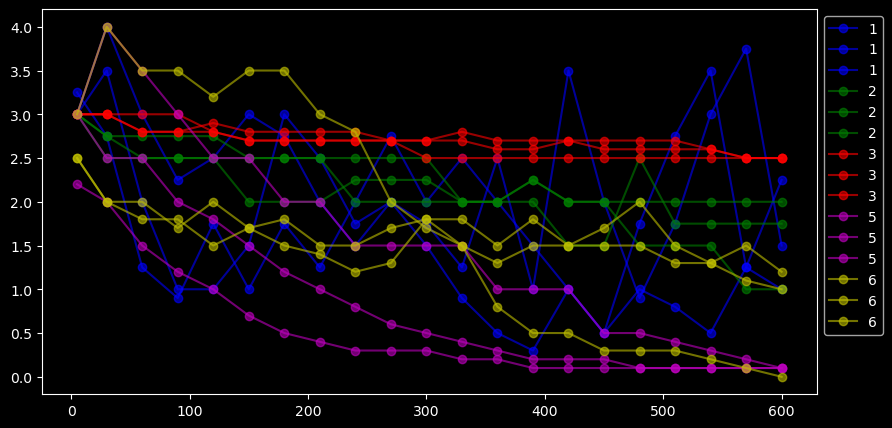

In [31]:
color_options = ["b", "g", "r", "c", "m", "y", "k"]
plt.figure(figsize=(10, 5))
plt.plot()
for i in tonic_data["pid"].unique():
    for t in tonic_data["trial"].unique():
        plt.plot(
            tonic_data["timepoint"].loc[
                (tonic_data["pid"] == i) & (tonic_data["trial"] == t)
            ],
            tonic_data["painrating"].loc[
                (tonic_data["pid"] == i) & (tonic_data["trial"] == t)
            ],
            "o-",
            c=color_options[int(i) - 1],
            label=i,
            alpha=0.6,
        )
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.show()

In [18]:
# data4boxplot = tonic_data["timepoint","painrating"]
data4boxplot = d.loc[:, "30":"600"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


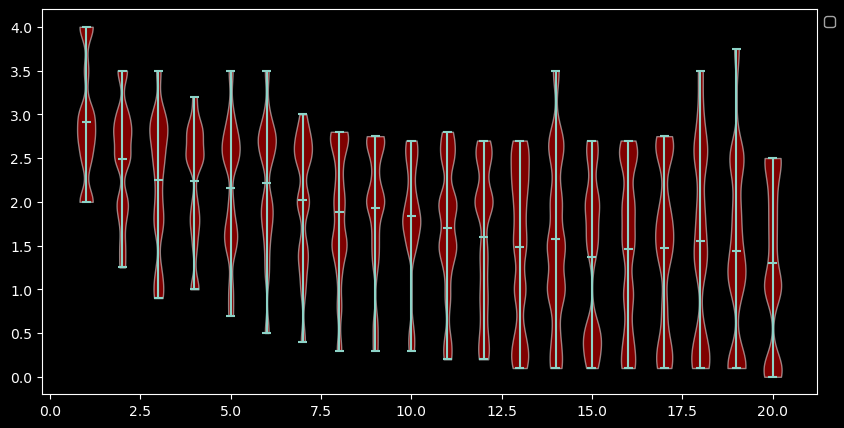

In [19]:
color_options = ["b", "g", "r", "c", "m", "y", "k"]
plt.figure(figsize=(10, 5))
plt.plot()

parts = plt.violinplot(
    dataset=data4boxplot,
    showmeans=True,
    points=100,
    bw_method=0.2,
)
# plt.scatter(np.arange(0,20,1),data4boxplot) #tonic_data["timepoint"], tonic_data["painrating"], c="black", alpha=0.5)
for pc in parts["bodies"]:
    pc.set_facecolor("red")
    pc.set_edgecolor("white")
    pc.set_alpha(0.5)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.show()


---

In [ ]:
t = np.tile(
    timepoints,
    d.shape[0],
).reshape(1, timepoints.shape[0] * d.shape[0])

pid = np.repeat(pid, timepoints.shape[0], axis=0).reshape(
    1, timepoints.shape[0] * d.shape[0]
)

# conds = np.repeat(conds, timepoints.shape[0]).reshape(1, timepoints.shape[0] * d.shape[0])

# transpose for easier viewing (tall vs wide)
rawdata = np.concatenate((pid, conds, t, y), axis=0).T

# sort raw data based on timepoint vector
rawdata_sorted = rawdata[rawdata[:, 2].argsort()]

In [5]:
# fit a linear regression model to the data
# def linear(x, m, b):
#     return m * x + b


# def fit_linear(x, y):
#     popt, pcov, infodict, _, _ = optimize.curve_fit(linear, x, y, full_output=True)
#     return popt, pcov, infodict


# def exponential(x, a, b, c):
#     return a * np.exp(-b * x) + c


# def fit_exp(x, y):
#     popt, pcov, infodict, _, _ = optimize.curve_fit(exponential, x, y, full_output=True, p0=[1, 1e-6, 1])
#     return popt, pcov, infodict

In [6]:
# Fit linear model to data
lf, lf_cov, lf_info, _ = fitting.fit_lin(rawdata_sorted[:, 2], rawdata_sorted[:, 3])
lf_y = fitting.linear(timepoints, *lf)
# Fit exponential model to data
ef, ef_cov, ef_info, _ = fitting.fit_exp(rawdata_sorted[:, 2], rawdata_sorted[:, 3])
ef_y = fitting.exponential(timepoints, *ef)
# Gather sub-indices to fit for each participant x condition data
pid_unique = np.unique(pid)
variable_idx = [True if "V" in element else False for element in rawdata_sorted[:, 1]]
tonic_idx = [True if "T" in element else False for element in rawdata_sorted[:, 1]]

In [6]:
# Fit exponential model to data
ef, ef_cov, ef_info, _ = fitting.fit_exp(rawdata_sorted[:, 2], rawdata_sorted[:, 3])
ef_y = fitting.exponential(timepoints, *ef)

In [7]:
# Gather sub-indices to fit for each participant x condition data
pid_unique = np.unique(pid)
variable_idx = [True if "V" in element else False for element in rawdata_sorted[:, 1]]
tonic_idx = [True if "T" in element else False for element in rawdata_sorted[:, 1]]

In [8]:
# Fit for each participant
def fit_per_participant(x, y):
    condition_fits = {"linear": {}, "exp": {}}
    (
        condition_fits["linear"]["ceoffs"],
        condition_fits["linear"]["cov"],
        condition_fits["linear"]["info"],
        _,
    ) = fitting.fit_lin(x, y)

    condition_fits["linear"]["fitted"] = fitting.linear(
        np.unique(x).astype(dtype=float), *condition_fits["linear"]["ceoffs"]
    )

    (
        condition_fits["exp"]["ceoffs"],
        condition_fits["exp"]["cov"],
        condition_fits["exp"]["info"],
        _,
    ) = fitting.fit_exp(x, y)
    condition_fits["exp"]["fitted"] = fitting.exponential(
        np.unique(x).astype(dtype=float), *condition_fits["exp"]["ceoffs"]
    )
    return condition_fits

In [9]:
# Loop through participants and fit for each condition
participant_fits = {}
# condition_fits = {"linear": {}, "exp": {}}
for p in pid_unique:
    # p = 1
    pid_index = rawdata_sorted[:, 0] == p
    tonic_index = tonic_idx & pid_index
    variable_index = variable_idx & pid_index

    tonic_data = rawdata_sorted[tonic_index, :]
    variable_data = rawdata_sorted[tonic_index, :]
    participant_fits[p] = {"tonic": {}, "variable": {}}

    participant_fits[p]["tonic"] = fit_per_participant(
        tonic_data[:, 2], tonic_data[:, 3]
    )
    participant_fits[p]["variable"] = fit_per_participant(
        variable_data[:, 2], variable_data[:, 3]
    )

In [9]:
filtered_elements = [element for element in rawdata_sorted[:, 1] if "T" in element]
filtered_indexes = [
    i for i, element in enumerate(rawdata_sorted[:, 1]) if "T" in element
]

In [56]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

for i, pp in enumerate(np.unique(rawdata_sorted[:, 0])):
    xdata = rawdata_sorted[rawdata_sorted[:, 0] == pp, :]
    xdata = xdata[tonic_idx]
    fig.add_trace(
        go.Scatter(
            x=xdata,
            y=rawdata_sorted[:, 3],
            mode="markers",
            name="data",
            marker=dict(
                size=10, opacity=0.5
            ),  # colorscale=px.colors.qualitative.Plotly[i]),
        )
    )
fig.add_trace(
    go.Scatter(
        x=timepoints,
        y=lf_y,
        mode="lines",
        name="linear fit",
        line=dict(color="red", width=2),
    )
)
# fig.add_trace(go.Scatter(x=timepoints, y=ef_y, mode="lines", name="exponential fit", line=dict(color="green", width=2)))
fig.update_layout(
    title="Pain ratings over time",
    xaxis_title="Time (s)",
    yaxis_title="Pain ratings",
    template="plotly_dark",
    width=1000,
    height=600,
)

for i, p in enumerate(participant_fits.keys()):
    fig.add_trace(
        go.Scatter(
            x=timepoints,
            y=participant_fits[p]["tonic"]["linear"]["fitted"],
            mode="lines",
            name="linear fit",
            line=dict(width=2),
        )
    )
# fig.add_trace(go.Scatter(x=timepoints, y=participant_fits[p]["tonic"]["linear"]["fitted"], mode="lines", name="linear fit", line=dict(color=px.colors.qualitative.Plotly[i], width=2)))
# fig.add_trace(go.Scatter(x=timepoints, y=participant_fits[p]["tonic"]["exp"]["fitted"], mode="lines", name="linear fit", line=dict(color=px.colors.qualitative.Plotly[i], width=2, dash="dash")))

fig.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 160 but corresponding boolean dimension is 560

In [59]:
tempfilt = rawdata_sorted[variable_idx, :]
t = tempfilt[tempfilt[:, 0] == 4, :]

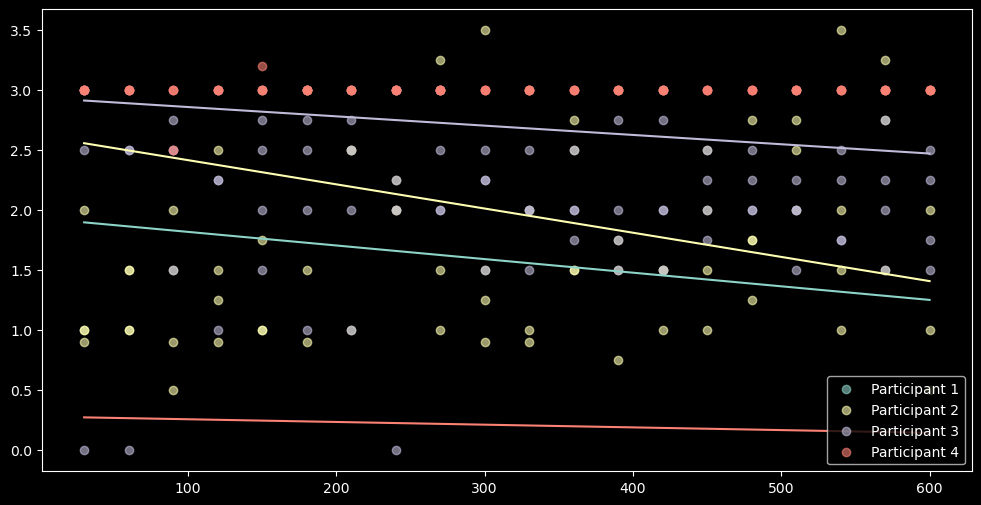

In [57]:
# plt.colorpallette("pastel1")


color_options = ["red", "blue", "green", "yellow"]
plt.figure(figsize=(12, 6))
tempfilt = rawdata_sorted[variable_idx, :]

for i, pp in enumerate(np.unique(rawdata_sorted[:, 0])):
    # filtdat = rawdata_sorted[rawdata_sorted[:, 0] == pp, :]

    filtdat = tempfilt[tempfilt[:, 0] == i, :]
    plt.scatter(
        filtdat[:, 2],
        filtdat[:, 3],
        # c=i,
        # cmap="Set1",
        alpha=0.6,
        label="Participant " + str(int(pp)),
    )

    plt.plot(
        timepoints, participant_fits[pp]["tonic"]["linear"]["fitted"]
    )  # olor_options[filtdat[:, 0].astype(int) - 1])

plt.legend()
plt.show()